In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/butterfly-dataset/leedsbutterfly/README.txt
/kaggle/input/butterfly-dataset/leedsbutterfly/images/0020155.png
/kaggle/input/butterfly-dataset/leedsbutterfly/images/0090177.png
/kaggle/input/butterfly-dataset/leedsbutterfly/images/0090201.png
/kaggle/input/butterfly-dataset/leedsbutterfly/images/0100038.png
/kaggle/input/butterfly-dataset/leedsbutterfly/images/0070055.png
/kaggle/input/butterfly-dataset/leedsbutterfly/images/0060059.png
/kaggle/input/butterfly-dataset/leedsbutterfly/images/0070068.png
/kaggle/input/butterfly-dataset/leedsbutterfly/images/0070044.png
/kaggle/input/butterfly-dataset/leedsbutterfly/images/0090114.png
/kaggle/input/butterfly-dataset/leedsbutterfly/images/0070099.png
/kaggle/input/butterfly-dataset/leedsbutterfly/images/0050049.png
/kaggle/input/butterfly-dataset/leedsbutterfly/images/0020112.png
/kaggle/input/butterfly-dataset/leedsbutterfly/images/0100023.png
/kaggle/input/butterfly-dataset/leedsbutterfly/images/0040082.png
/kaggle/input/butt

# Importing Modules

In [2]:
import os
import numpy as np
import re
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import time
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

# Getting Basic Stats

In [3]:
# Path to the dataset directories
image_path = '/kaggle/input/butterfly-dataset/leedsbutterfly/images'
mask_path = '/kaggle/input/butterfly-dataset/leedsbutterfly/segmentations'

In [4]:
# List images and masks
images = os.listdir(image_path)
masks = os.listdir(mask_path)
# Display data statistics
print(f"The Data statistics\n images: {len(images)} masks: {len(masks)}")

The Data statistics
 images: 832 masks: 832


In [5]:
# Function to find the corresponding mask for a given image
def get_corresponding_mask(image_name):
    base_name = image_name.split('.')[0]  # Extract base name (e.g., '0010001')
    mask_name = f"{base_name}_seg0.png"   # Append '_seg0' to match the mask pattern
    return mask_name

In [6]:
# Display a few sample images and their corresponding masks
def show_samples(image_list, num_samples=3):
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        img = Image.open(os.path.join(image_path, image_list[i]))
        mask_name = get_corresponding_mask(image_list[i])
        mask = Image.open(os.path.join(mask_path, mask_name))
        
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(img)
        plt.title("Image")
        plt.axis("off")
        
        plt.subplot(2, num_samples, num_samples + i + 1)
        plt.imshow(mask)
        plt.title("Mask")
        plt.axis("off")
    
    plt.show()

In [ ]:
# Show 3 samples
show_samples(images, num_samples=3)

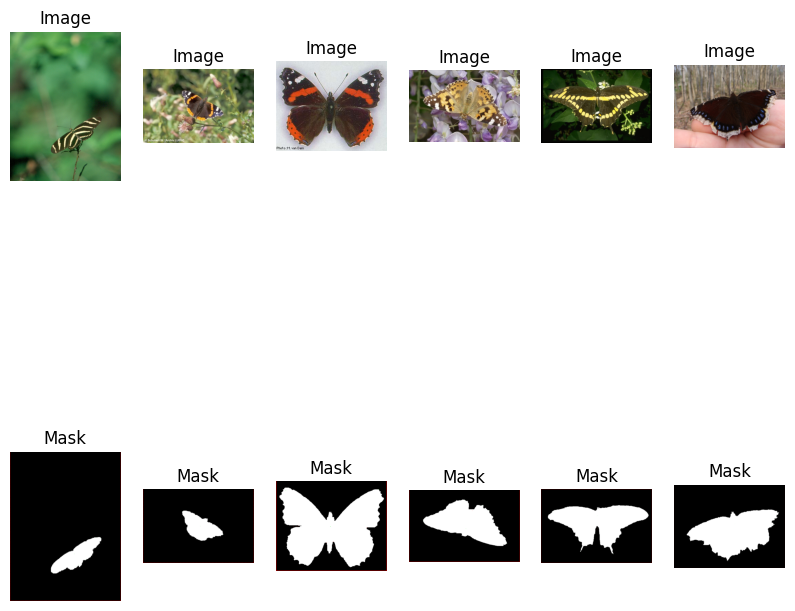

In [ ]:
# Show 3 samples
show_samples(images, num_samples=6)

# Load Data 
- Load the data in numpy format. 
- Less quality data. Total size is like 500 mb.
- If data is larger and larger, intialise data generators. 
- KERAS IMAGE FROM DATASET.
- Resizing. 
- INTIALISE generator for masks and then original images.

256 ---> 128 ---> 64 ---> 32 ---> 16 ---> 32 ---> 64 --->128 --->256

In [9]:
# Function to load and preprocess the dataset
def load_data(image_dir, mask_dir, image_shape=256):
    """
    Loads and preprocesses images and masks for training.

    Args:
        image_dir (str): Directory containing the images.
        mask_dir (str): Directory containing the masks.
        image_shape (int, optional): Shape to resize the images and masks. Defaults to 256.

    Returns:
        tuple: Arrays of preprocessed images and masks.
    """
    image_list = []
    mask_list = []
    
    # Create a dictionary as well, in which we have key as the original image and mask as the value.
    

    image_names = os.listdir(image_dir)
    mask_names = [re.sub(r'\.png', '_seg0.png', name) for name in image_names]

    for img_name, mask_name in zip(image_names, mask_names):
        try:
            img = plt.imread(os.path.join(image_dir, img_name))
            mask = plt.imread(os.path.join(mask_dir, mask_name))
        except FileNotFoundError:
            print("Exception hapened as the file is not found.")
            continue

        # Resizing the images and masks
        img_resized = cv2.resize(img, (image_shape, image_shape))
        mask_resized = cv2.resize(mask, (image_shape, image_shape))

        # Storing the preprocessed data
        image_list.append(img_resized)
        mask_list.append(mask_resized[:, :, 0])  # Use the first channel for binary masks

    return np.array(image_list), np.array(mask_list)

In [10]:
# Load data
image_dir = '/kaggle/input/butterfly-dataset/leedsbutterfly/images'
mask_dir = '/kaggle/input/butterfly-dataset/leedsbutterfly/segmentations'
images, masks = load_data(image_dir, mask_dir)

In [11]:
images.shape, masks.shape

((832, 256, 256, 3), (832, 256, 256))

-- You need to divide the data into 3 parts. 
-- Training, Validation , Testing.

# Test Train Split

In [12]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

In [13]:
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(665, 256, 256, 3) (167, 256, 256, 3) (665, 256, 256) (167, 256, 256)


In [14]:
# try to do imread on these numpy arrays and then imshow on these.
X_train[0], y_train[0]

(array([[[5.18936276e-01, 7.52047479e-01, 3.79942685e-01],
         [5.62345684e-01, 7.80606270e-01, 4.31203276e-01],
         [6.68411076e-01, 8.78325403e-01, 5.49136996e-01],
         ...,
         [1.96273118e-01, 3.57057452e-01, 5.78233600e-02],
         [2.19239816e-01, 3.82735521e-01, 6.47974089e-02],
         [2.28370100e-01, 4.00474876e-01, 7.71675929e-02]],
 
        [[5.07382810e-01, 7.45265782e-01, 3.57068777e-01],
         [5.20916462e-01, 7.47130752e-01, 3.70118678e-01],
         [5.73132992e-01, 7.91408122e-01, 4.25978333e-01],
         ...,
         [2.23232642e-01, 3.85508597e-01, 8.60773176e-02],
         [2.42049634e-01, 4.07239228e-01, 8.89016539e-02],
         [2.43650436e-01, 4.20121014e-01, 9.72196758e-02]],
 
        [[5.04146934e-01, 7.48984516e-01, 3.57722521e-01],
         [5.04444361e-01, 7.40914106e-01, 3.49345088e-01],
         [5.11610210e-01, 7.41482198e-01, 3.47163290e-01],
         ...,
         [2.20205277e-01, 3.87079448e-01, 8.65272731e-02],
        

# Let's Start Builing UNET Architecture
## Building Convolution Block

In [15]:
# Function to create a convolutional block for the U-Net model
def convolutional_block(input_tensor, num_filters, kernel_size=3, use_batch_norm=True):
    """
    Performs two convolution operations with optional batch normalization.

    Args:
        input_tensor (tensor): Input to the convolutional block.
        num_filters (int): Number of filters for the convolutional layers.
        kernel_size (int, optional): Size of the convolution kernel. Defaults to 3.
        use_batch_norm (bool, optional): Apply batch normalization if True. Defaults to True.

    Returns:
        tensor: Output after applying convolution, batch normalization, and activation.
    """
    # First convolution
    x = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=(kernel_size, kernel_size),
                               kernel_initializer='he_normal', padding='same')(input_tensor)
    if use_batch_norm:
        x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    # Second convolution
    x = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=(kernel_size, kernel_size),
                               kernel_initializer='he_normal', padding='same')(x)
    if use_batch_norm:
        x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    return x

## Building UNET Model

In [16]:
# Function to create a U-Net model
def build_unet(input_shape, num_filters=16, dropout_rate=0.1, use_batch_norm=True):
    """
    Builds a U-Net model.

    Args:
        input_shape (tuple): Shape of the input image (height, width, channels).
        num_filters (int, optional): Number of filters for the initial layer. Defaults to 16.
        dropout_rate (float, optional): Dropout rate for regularization. Defaults to 0.1.
        use_batch_norm (bool, optional): Apply batch normalization if True. Defaults to True.

    Returns:
        keras.Model: Compiled U-Net model.
    """
    inputs = tf.keras.layers.Input(input_shape)

    # Encoder path
    c1 = convolutional_block(inputs, num_filters * 1, use_batch_norm=use_batch_norm)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)
    p1 = tf.keras.layers.Dropout(dropout_rate)(p1)

    c2 = convolutional_block(p1, num_filters * 2, use_batch_norm=use_batch_norm)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
    p2 = tf.keras.layers.Dropout(dropout_rate)(p2)

    c3 = convolutional_block(p2, num_filters * 4, use_batch_norm=use_batch_norm)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
    p3 = tf.keras.layers.Dropout(dropout_rate)(p3)

    c4 = convolutional_block(p3, num_filters * 8, use_batch_norm=use_batch_norm)
    p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)
    p4 = tf.keras.layers.Dropout(dropout_rate)(p4)

    # Bottleneck
    c5 = convolutional_block(p4, num_filters * 16, use_batch_norm=use_batch_norm)

    # Decoder path
    u6 = tf.keras.layers.Conv2DTranspose(num_filters * 8, (3, 3), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(dropout_rate)(u6)
    c6 = convolutional_block(u6, num_filters * 8, use_batch_norm=use_batch_norm)

    u7 = tf.keras.layers.Conv2DTranspose(num_filters * 4, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(dropout_rate)(u7)
    c7 = convolutional_block(u7, num_filters * 4, use_batch_norm=use_batch_norm)

    u8 = tf.keras.layers.Conv2DTranspose(num_filters * 2, (3, 3), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(dropout_rate)(u8)
    c8 = convolutional_block(u8, num_filters * 2, use_batch_norm=use_batch_norm)

    u9 = tf.keras.layers.Conv2DTranspose(num_filters * 1, (3, 3), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(dropout_rate)(u9)
    c9 = convolutional_block(u9, num_filters * 1, use_batch_norm=use_batch_norm)

    # Output layer
    output = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    # Model creation
    model = tf.keras.Model(inputs=[inputs], outputs=[output])
    return model


In [17]:
# Instantiate and compile the U-Net model
input_shape = (256, 256, 3)
unet_model = build_unet(input_shape, dropout_rate=0.07)
unet_model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
unet_model.summary()

Model: "functional"

 Non-trainable params: 2,944 (11.50 KB)

In [19]:
%%capture
!pip install visualkeras

In [ ]:
from visualkeras import layered_view
import visualkeras
visualkeras.layered_view(unet_model)

/usr/local/lib/python3.10/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


In [21]:
from tensorflow.keras.utils import plot_model
plot_model(unet_model, to_file='UnetArchitecture.png', show_shapes=False, show_layer_names=True)

In [22]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('unet_model_best.keras', monitor='val_loss', save_best_only=True, verbose=1)

In [23]:
# Train the model
history = unet_model.fit(X_train, 
                         y_train, 
                         validation_data=(X_val, y_val), 
                         epochs=50, 
                         verbose=1,
                         callbacks=[early_stopping, reduce_lr, model_checkpoint])

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7351 - loss: 0.5475   
Epoch 1: val_loss improved from inf to 2.68220, saving model to unet_model_best.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.7381 - loss: 0.5431 - val_accuracy: 0.4988 - val_loss: 2.6822 - learning_rate: 0.0010
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.8830 - loss: 0.2908
Epoch 2: val_loss did not improve from 2.68220
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 336ms/step - accuracy: 0.8833 - loss: 0.2900 - val_accuracy: 0.6950 - val_loss: 2.9934 - learning_rate: 0.0010
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.8977 - loss: 0.2476
Epoch 3: val_loss improved from 2.68220 to 0.73526, saving model to unet_model_best.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 356ms/step - accuracy: 0.8977 - loss: 0.2473 - val_accuracy: 0.8592 - val_loss: 0.7353 - learning_rate: 0.0010
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.9112 - loss: 0.2139
Epoch 4: val

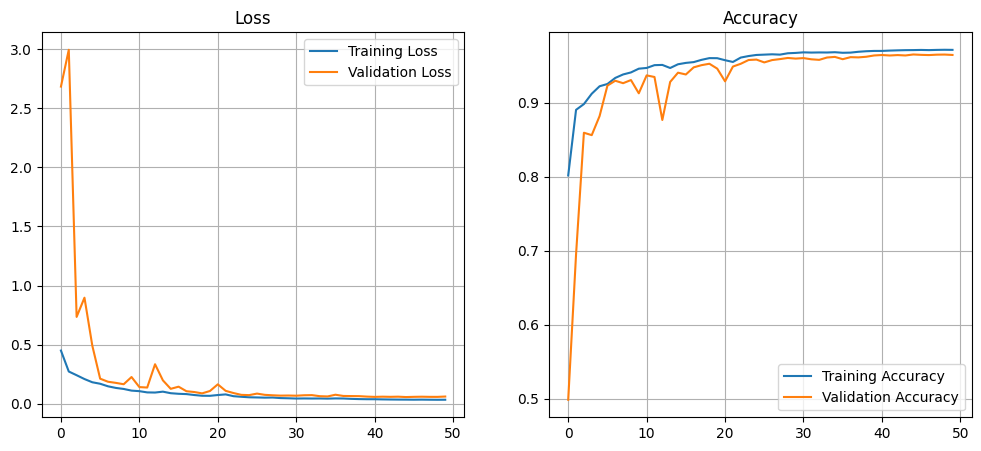

In [24]:
# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.grid()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy')

plt.show()

In [25]:
# Function to predict and time the inference for a single image
def predict_single_image(image, model):
    """
    Predicts the segmentation mask for a single image and times the prediction.

    Args:
        image (array): Input image for prediction.
        model (keras.Model): Trained U-Net model.

    Returns:
        tuple: Predicted mask and inference time.
    """
    start_time = time.time()
    prediction = model.predict(np.expand_dims(image, axis=0))[0, :, :, 0]
    end_time = time.time()
    inference_time = end_time - start_time

    return prediction, inference_time

In [26]:
# Function to visualize the prediction and ground truth
def visualize_segmentation(image, predicted_mask, ground_truth_mask):
    """
    Visualizes the original image, predicted mask, and ground truth mask.

    Args:
        image (array): Original image.
        predicted_mask (array): Predicted mask.
        ground_truth_mask (array): Ground truth mask.
    """
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title('Predicted Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(ground_truth_mask, cmap='gray')
    plt.title('Ground Truth Mask')

    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Inference time for a single image: 2.0414 seconds


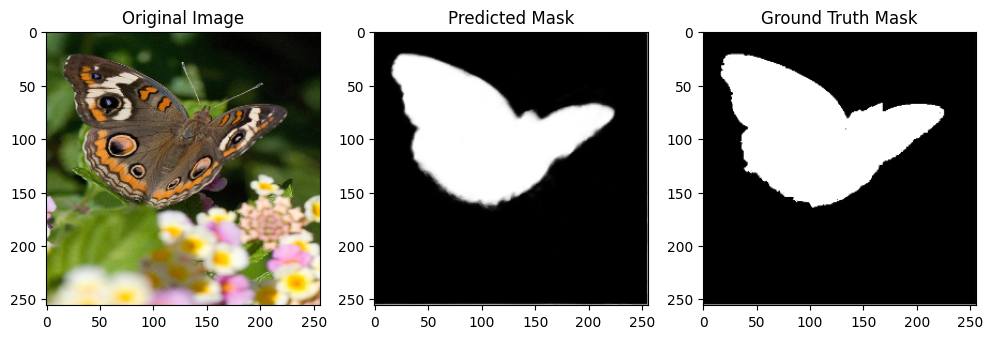

In [27]:
# Example inference on a validation image
sample_image = X_val[0]
sample_ground_truth = y_val[0]

predicted_mask, inference_time = predict_single_image(sample_image, unet_model)
print(f'Inference time for a single image: {inference_time:.4f} seconds')

# Visualize the result
visualize_segmentation(sample_image, predicted_mask, sample_ground_truth)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Inference time for a single image: 0.0567 seconds


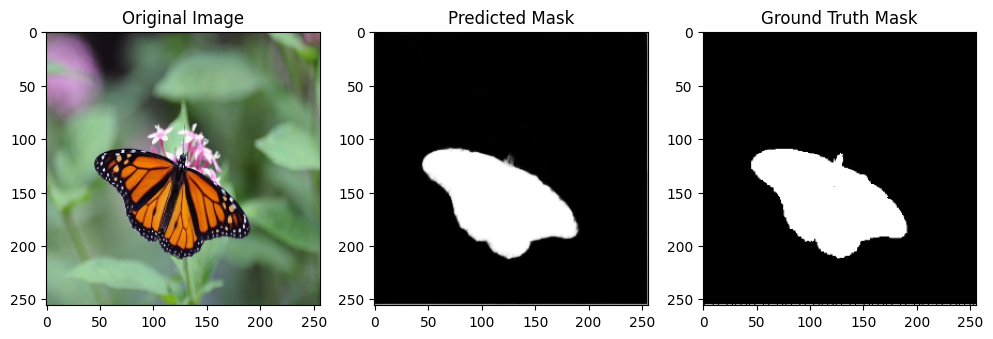

In [28]:
# Example inference on a validation image
sample_image = X_val[10]
sample_ground_truth = y_val[10]

predicted_mask, inference_time = predict_single_image(sample_image, unet_model)
print(f'Inference time for a single image: {inference_time:.4f} seconds')

# Visualize the result
visualize_segmentation(sample_image, predicted_mask, sample_ground_truth)

 - 0.06 seconds.
 - 30 frames per second. 
 - 24 frames per second.
 - 1*1/0.06 -- 16.66 images per second
 - reduce the image

# Calculating Mean IOU Score

In [29]:
import tensorflow.keras.backend as K
def mean_iou(y_true, y_pred, smooth=1):
    """
    Calculate the mean Intersection over Union (IoU).

    Args:
        y_true (tensor): Ground truth mask.
        y_pred (tensor): Predicted mask.
        smooth (float, optional): Smoothing factor to avoid division by zero. Defaults to 1.

    Returns:
        float: Mean IoU score.
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

In [30]:
# Get predictions
y_pred = unet_model.predict(X_val)
print(mean_iou(y_val,y_pred))

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step
tf.Tensor(0.8883444, shape=(), dtype=float32)


In [31]:
# Get predictions
y_pred = unet_model.predict(X_train)
print(mean_iou(y_train,y_pred))

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step
tf.Tensor(0.91536963, shape=(), dtype=float32)


# Adding IOU to the metrics while training Model

In [32]:
import tensorflow.keras.backend as K

def dice_coefficient(y_true, y_pred, smooth=1):
    """
    Calculate the Dice coefficient.

    Args:
        y_true (tensor): Ground truth mask.
        y_pred (tensor): Predicted mask.
        smooth (float, optional): Smoothing factor to avoid division by zero. Defaults to 1.

    Returns:
        float: Dice coefficient score.
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def mean_iou(y_true, y_pred, smooth=1):
    """
    Calculate the mean Intersection over Union (IoU).

    Args:
        y_true (tensor): Ground truth mask.
        y_pred (tensor): Predicted mask.
        smooth (float, optional): Smoothing factor to avoid division by zero. Defaults to 1.

    Returns:
        float: Mean IoU score.
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

In [33]:
input_shape = (256, 256, 3)
unet_model = build_unet(input_shape, dropout_rate=0.07)

In [34]:
# Compile the U-Net model with Dice coefficient and mean IoU as metrics
unet_model.compile(optimizer='Adam', loss='binary_crossentropy', 
                   metrics=['accuracy', dice_coefficient, mean_iou])

In [35]:
# Train the model with the additional metrics
history = unet_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, verbose=1)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.7045 - dice_coefficient: 0.4730 - loss: 0.5896 - mean_iou: 0.3115 - val_accuracy: 0.3269 - val_dice_coefficient: 0.4247 - val_loss: 9.6650 - val_mean_iou: 0.2699
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 330ms/step - accuracy: 0.8835 - dice_coefficient: 0.6278 - loss: 0.3316 - mean_iou: 0.4578 - val_accuracy: 0.6989 - val_dice_coefficient: 0.5621 - val_loss: 2.9562 - val_mean_iou: 0.3911
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 334ms/step - accuracy: 0.9068 - dice_coefficient: 0.6673 - loss: 0.2694 - mean_iou: 0.5010 - val_accuracy: 0.6852 - val_dice_coefficient: 0.5915 - val_loss: 3.2620 - val_mean_iou: 0.4203
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 339ms/step - accuracy: 0.9218 - dice_coefficient: 0.7136 - loss: 0.2262 - mean_iou: 0.5548 - val_accuracy: 0.7875 - val_dice_coefficient: 0.6625 - val_loss: 1.4696 - val_mean_iou: 0.4955
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 339ms/step - accuracy: 0.9239 - dice_coefficient:

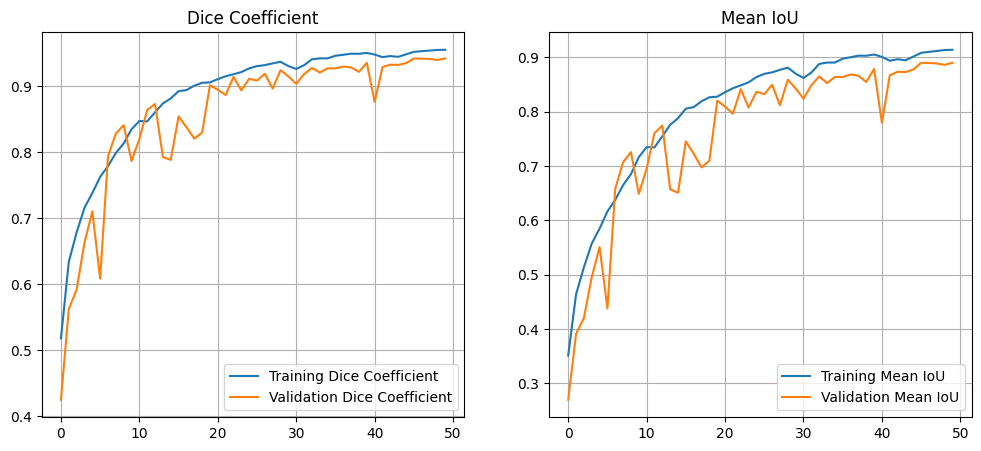

In [36]:
# Plot Dice coefficient and mean IoU during training and validation
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['dice_coefficient'], label='Training Dice Coefficient')
plt.plot(history.history['val_dice_coefficient'], label='Validation Dice Coefficient')
plt.legend()
plt.grid()
plt.title('Dice Coefficient')

plt.subplot(1, 2, 2)
plt.plot(history.history['mean_iou'], label='Training Mean IoU')
plt.plot(history.history['val_mean_iou'], label='Validation Mean IoU')
plt.legend()
plt.grid()
plt.title('Mean IoU')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 923ms/step


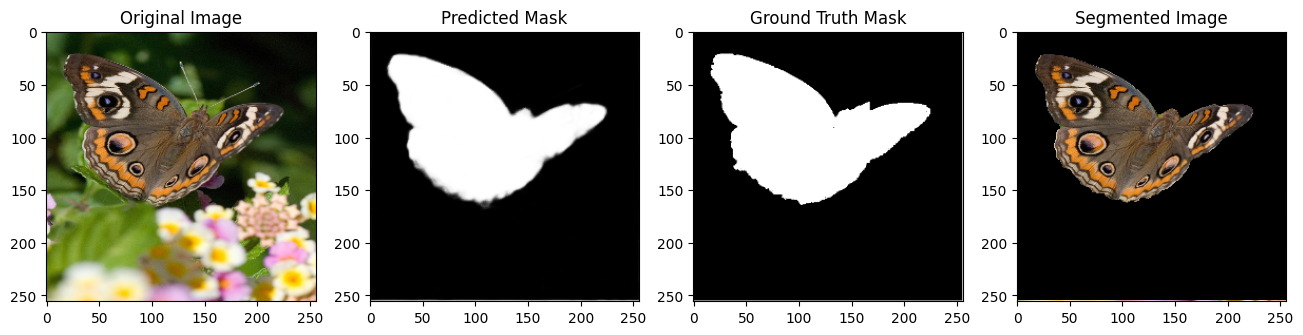

In [37]:
def visualize_segmentation_with_cropping(image, predicted_mask, ground_truth_mask):
    """
    Visualizes the original image, predicted mask, ground truth mask, and segmented image.

    Args:
        image (array): Original image.
        predicted_mask (array): Predicted mask.
        ground_truth_mask (array): Ground truth mask.
    """
    # Threshold the predicted mask to create a binary mask for segmentation
    binary_mask = (predicted_mask > 0.5).astype(np.uint8)
    
    # Plotting the original image, predicted mask, ground truth mask, and segmented image
    plt.figure(figsize=(16, 4))

    plt.subplot(1, 4, 1)
    plt.imshow(image)
    plt.title('Original Image')

    plt.subplot(1, 4, 2)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title('Predicted Mask')

    plt.subplot(1, 4, 3)
    plt.imshow(ground_truth_mask, cmap='gray')
    plt.title('Ground Truth Mask')
    
    # Apply the binary mask to the original image to create the segmented output
    segmented_image = cv2.merge((binary_mask, binary_mask, binary_mask)) * image
    
    plt.subplot(1, 4, 4)
    plt.imshow(segmented_image)
    plt.title('Segmented Image')

    plt.show()

# Example usage
sample_image = X_val[0]
sample_ground_truth = y_val[0]

predicted_mask, _ = predict_single_image(sample_image, unet_model)

# Visualize the segmentation results with cropping
visualize_segmentation_with_cropping(sample_image, predicted_mask, sample_ground_truth)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


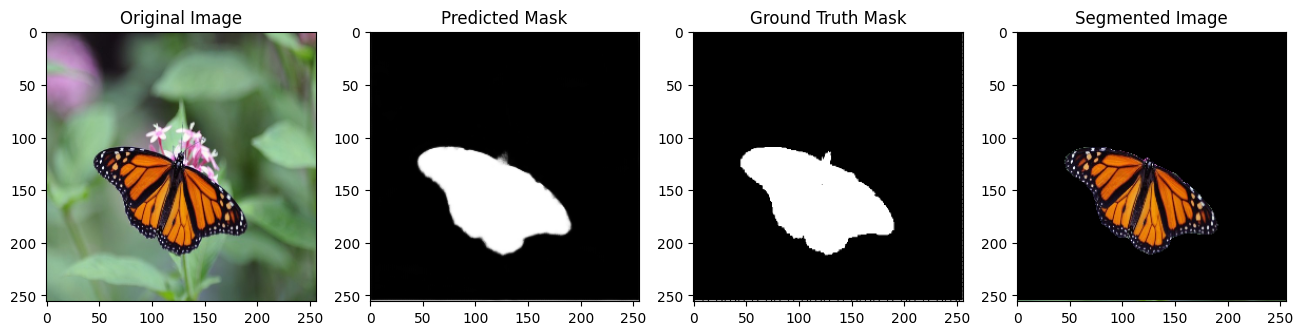

In [38]:
# Example usage
sample_image = X_val[10]
sample_ground_truth = y_val[10]

predicted_mask, _ = predict_single_image(sample_image, unet_model)

# Visualize the segmentation results with cropping
visualize_segmentation_with_cropping(sample_image, predicted_mask, sample_ground_truth)


In [39]:
unet_model.save('final_UNET_Butterfly_Segmentation.keras')

In [1]:
unet_model.save('final_UNET_Butterfly_Segmentation.h5')

NameError: name 'unet_model' is not defined

In [40]:
new_model = model.load()

NameError: name 'model' is not defined

In [43]:
# Importing necessary library
from tensorflow.keras.models import load_model

# Loading the model
model = load_model("final_UNET_Butterfly_Segmentation.keras")

# Verifying the model
model.summary()

# Using the model for prediction
# Replace X_test with your input data
predictions = model.predict(X_test)


TypeError: Could not locate function 'dice_coefficient'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'builtins', 'class_name': 'function', 'config': 'dice_coefficient', 'registered_name': 'function'}